In [2]:
%matplotlib inline
import sys, os
sys.path.append("../")
import numpy as np
import numpy.linalg as nla
import scipy.linalg as sla
import numba as nb
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import timeit
import matplotlib.pylab as pl
# import ot
# import ot.plot
# from ot.datasets import make_1D_gauss as gauss
# from drot.solver import drot, PDHG
# from drot.proximal import *
%load_ext autoreload
%autoreload 2

# Optimal transport

In [2]:
def one_dimensional_gaussian_ot(n):
    t = np.arange(0, n)/n
    Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2 / (2*sigma**2))
    normalize = lambda p: p / np.sum(p)
    sigma = 0.1;
    p = Gaussian(.75, sigma)
    q = Gaussian(.15, sigma)
    vmin = .02;
    p = normalize(p + np.max(p) * vmin)
    q = normalize(q + np.max(q) * vmin)
    [Y,X] = np.meshgrid(t,t)
    C = np.array((X-Y)**2, order='F')
    # C = np.array(np.abs(X-Y), order='F')
    return n, C, p, q

def two_dimensional_gaussian_ot(m, n):
    mu_s = np.array([0, 0.5])
    cov_s = np.array([[1, 0.5], [0.5, 1]])
    mu_t = np.array([4, 10])
    cov_t = np.array([[1, -.8], [-.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((m,)) / m, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt), order='F')
    C /= C.max()

    return m, n, C, p, q

Solve time:  0.08997607231140137
Solve time:  0.05231213569641113


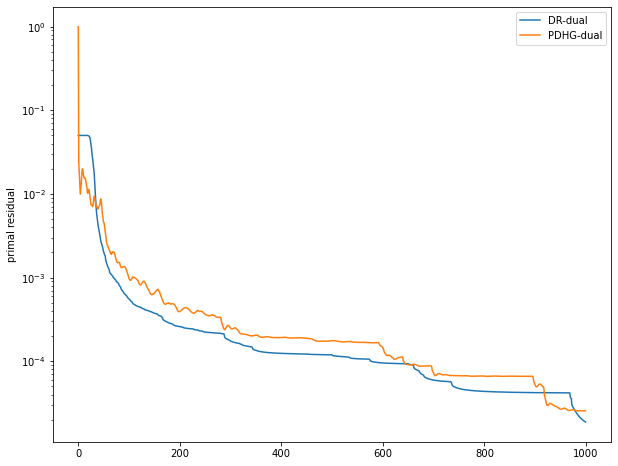

In [3]:
max_iters = 1000
step = 0.1

m, n, C, p, q = two_dimensional_gaussian_ot(20, 20)
x0 = np.ones((m, n), order='F') / n
eta, tau = (1/(m+n))**0.5, (1/(m+n))**0.5

assert C.flags['F_CONTIGUOUS']   
assert x0.flags['F_CONTIGUOUS']   

proxf = lambda x, stz: trace_nonnegative_prox(x, C, stz)
proxg = lambda x, stz: generalized_doubly_stochastic_matrices_projection(x, p, q)
proxg_ = lambda x, y, stz: primal_dual_trace_nonnegative_prox(x, C, y, stz)
proxh = lambda x, xnew, y, stz: primal_dual_linear_prox(x, xnew, y, p, q, stz)

drout  = drot(x0, proxf, proxg, np.hstack((p,q)), max_iters, step=step, relaxation=1.5, compute_r_primal=True, compute_r_dual=True, adapt_stepsize=False, fixed_restart=True, milestones=[100, 500, 1000], eps_abs=1e-10, eps_rel=1e-10)
cpout  = PDHG(x0, proxg_, proxh, max_iters, eta=eta, tau=tau, relaxation=1.0)

xopt = drout["sol"]
xopt_cp = cpout["sol"]

plt.figure(1, figsize=(10,8))
# plt.plot(range(drout["num_iters"]), [r for r in drout['primal']], label='DR-primal')
plt.plot(range(drout["num_iters"]), [r for r in drout['dual']], label='DR-dual')
plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

# plt.figure(2, figsize=(10,8))
plt.plot(range(cpout["num_iters"]), [r for r in cpout['dual']], label='PDHG-dual')
# plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

In [6]:
C_ = C.copy()
G0 = ot.emd(p, q, C_)
Gs = ot.sinkhorn(p, q, C_, 1e-3, verbose=False)
nla.norm(xopt - G0, ord='fro'),\
nla.norm(Gs - G0, ord='fro')

(0.10880353669121372, 0.16176974672813882)

In [7]:
np.sum(G0 >= 1e-14) 

20

In [10]:
np.trace(xopt.T.dot(C)), np.trace(G0.T.dot(C_)), np.trace(Gs.T.dot(C_))

(0.6603175508576733, 0.6601540878442813, 3.801880069062384e-188)

Text(0.5, 1.0, 'OT matrix Sinkhorn')

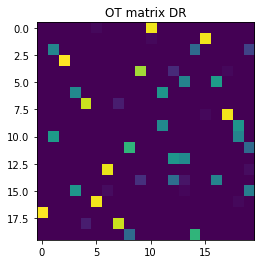

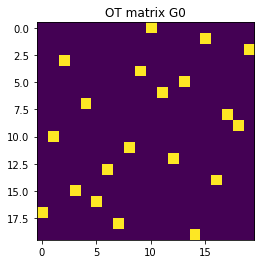

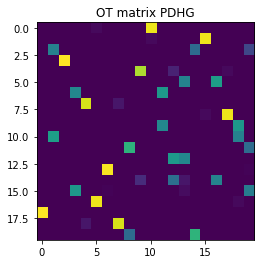

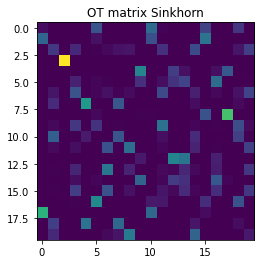

In [8]:
pl.figure(1)
pl.imshow(xopt, interpolation='nearest')
pl.title('OT matrix DR')

pl.figure(2)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
pl.imshow(xopt_cp, interpolation='nearest')
pl.title('OT matrix PDHG')

pl.figure(3)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix Sinkhorn')

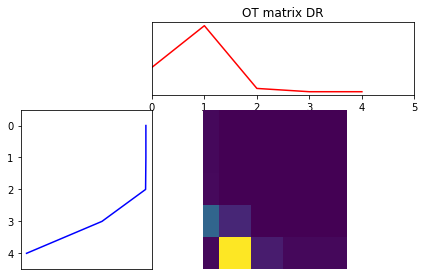

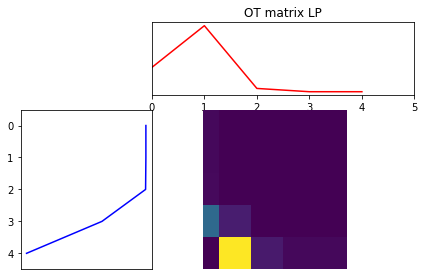

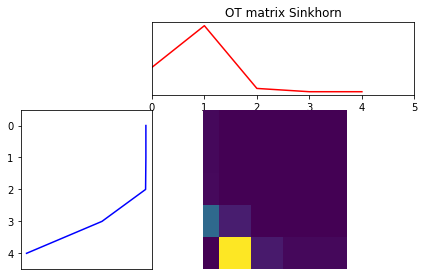

In [18]:
pl.figure(3, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, xopt.T, 'OT matrix DR')
# pl.title("---")

pl.figure(6, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, G0, 'OT matrix LP')

pl.figure(9, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, Gs, 'OT matrix Sinkhorn')
pl.show()

In [9]:
def apply_adjoint_operator(e, f, y, x, T, alpha=1.0, beta=None):
    """
        T <- T + alpha * y e^T + beta* f x^T
    """
    assert T.flags['F_CONTIGUOUS']
    assert e.size == x.size, "Dimension mismatch" 
    assert f.size == y.size, "Dimension mismatch"
    if beta is None:
        beta = alpha
    # print("Y1: ", Y)        
    Y = sp.linalg.blas.dger(alpha, y, e, a=T, overwrite_a=0)
    # print("Y2: ", Y)        
    assert Y.flags['F_CONTIGUOUS']
    sp.linalg.blas.dger(beta, f, x, a=Y, overwrite_a=1)
    # print("Y3: ", Y)        
    return Y

def apply_adjoint_operator_and_override(e, f, y, x, T, alpha=1.0, beta=None):
    """
        T <- T + alpha * y e^T + beta* f x^T
    """
    assert T.flags['F_CONTIGUOUS']
    assert e.size == x.size, "Dimension mismatch" 
    assert f.size == y.size, "Dimension mismatch"
    if beta is None:
        beta = alpha
    sp.linalg.blas.dger(alpha, y, e, a=T, overwrite_a=1)
    sp.linalg.blas.dger(beta, f, x, a=T, overwrite_a=1)
    return T    

In [10]:
# import sp.linalg as sla

m, n = 10000, 10000
A = np.random.randn(m, n)
e = np.ones(n)
f = np.ones(m)
s = np.random.rand(n)
r = np.random.rand(m)
s, r = r / np.sum(r), s / np.sum(s)

A = np.array(A, order='F')
B = np.array(A, order='F')

assert np.allclose(A, B)            


In [ ]:
%whos

In [33]:
# %timeit B = apply_adjoint_operator(e, f, s, r, A, alpha=1.0, beta=1.5)

# assert A.flags['F_CONTIGUOUS']
%timeit B = sla.blas.dger(1.4, s, e, a=A, overwrite_a=0)

59 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit np.subtract(A, 1.4*np.outer(s, e), out=A, order='F')

733 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [126]:
%timeit sla.blas.dger(-1.4, s, e, a=B, overwrite_a=1)

21.5 ms ± 64.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
b = np.sum(A, axis=0)
c = A.T.dot(f)
d = sla.blas.dgemv(1, A, f, trans=1)

In [13]:
assert np.allclose(b,c)
assert np.allclose(c,d)

In [84]:
%timeit np.maximum(B, 0)

656 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
%timeit A[A < 0] = 0

102 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit np.maximum(B - 2.0 * A, 0.0)

745 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%timeit np.maximum(A, 0.0)

297 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
from numba import types
from numba.extending import overload
from numba import config, njit, threading_layer, set_num_threads

@overload(np.maximum)
def impl_clip(x, a):
    # In numba type checking happens at *compile time*. We check the types of
    # the arguments here, and return a proper implementation based on those
    # types (or error accordingly).

    # Check that `a` is a scalar
    if not isinstance(a, (types.Integer, types.Float, types.NoneType)):
        raise TypingError("a must be a scalar int/float")

    if isinstance(x, (types.Integer, types.Float)):
        # x is a scalar with a valid type
        def impl(x, a):
            return max(x, a)    
    elif (
        isinstance(x, types.Array) and
        x.ndim == 1 and
        isinstance(x.dtype, (types.Integer, types.Float))
    ):
        # x is a 1D array of the proper type
        def impl(x, a):
            # Allocate an output array using standard numpy functions
#             out = np.empty_like(x)
            # Iterate over x, calling `np.clip` on every element
            for i in range(x.size):
                # This will dispatch to the proper scalar implementation (as
                # defined above) at *compile time*. There should have no
                # overhead at runtime.
                x[i] = impl(x[i], 0)
            return x
    elif ( 
        isinstance(x, types.Array) and
        x.ndim == 2 and
        isinstance(x.dtype, (types.Integer, types.Float))
    ):   
        def impl(x, a):
            return impl(x.reshape(-1), a)
    else:
        raise TypingError("x must be an int/float or a 1D/2D array of ints/floats")

    return impl

# @overload(np.maximum)
# def my_clip(x, a):
#     # In numba type checking happens at *compile time*. We check the types of
#     # the arguments here, and return a proper implementation based on those
#     # types (or error accordingly).

#     # Check that `a` is a scalar
#     if not isinstance(a, (types.Integer, types.Float, types.NoneType)):
#         raise TypingError("a must be a scalar int/float")

#     if isinstance(x, (types.Integer, types.Float)):
#         # x is a scalar with a valid type
#         def impl(x, a):
#             return max(x, a)    
#     elif (
#         isinstance(x, types.Array) and
#         x.ndim == 1 and
#         isinstance(x.dtype, (types.Integer, types.Float))
#     ):
#         # x is a 1D array of the proper type
#         def impl(x, a):
#             # Allocate an output array using standard numpy functions
# #             out = np.empty_like(x)
#             # Iterate over x, calling `np.clip` on every element
#             for i in range(x.size):
#                 # This will dispatch to the proper scalar implementation (as
#                 # defined above) at *compile time*. There should have no
#                 # overhead at runtime.
#                 x[i] = impl(x[i], 0)
#             return x
#     elif ( 
#         isinstance(x, types.Array) and
#         x.ndim == 2 and
#         isinstance(x.dtype, (types.Integer, types.Float))
#     ):   
#         def impl(x, a):
#             for i in range(x.shape[0]):
#                 np.maximum(x[i, :], a, out=x[i, :])
#             return x
#     else:
#         raise TypingError("x must be an int/float or a 1D/2D array of ints/floats")

#     return impl

In [31]:
# @nb.njit (cache=True, fastmath=True, parallel=True, nogil=True)
@nb.vectorize(['float64, float64'], target='parallel')
def test_clip(x, amin):
    return np.maximum(x, amin)

# config.THREADING_LAYER = 'threadsafe'
# print("Threading layer chosen: %s" % threading_layer())

nb.set_num_threads(4)
nb.config.NUMBA_DEFAULT_NUM_THREADS, nb.config.NUMBA_NUM_THREADS

(8, 8)

In [7]:
p = np.random.randn(5000, 7000)

In [30]:
%timeit test_clip(p, 0)

73.2 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%timeit np.maximum(p, 0)

184 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
%timeit A[A < 0] = 0

102 ms ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
%timeit numba_max(C)

645 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [137]:
%timeit global B; B -= 2.0*A 

78 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit np.subtract(B, 2.0*A, out=B, order='F')

71.5 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit sla.blas.daxpy(A, B, a=-2.0)

117 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [110]:
assert np.allclose(C, B)

In [15]:
%timeit A.T.dot(f)

40 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [139]:
%timeit sla.blas.dgemv(1, A, f, trans=1)

9.89 ms ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit np.sum(A, axis=1)

64.2 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit apply_adjoint_operator_and_override(e, f, s, r, A, alpha=1.0, beta=1.5)

NameError: name 'apply_adjoint_operator_and_override' is not defined

In [14]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/vienmai/miniconda3/envs/common/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/vienmai/miniconda3/envs/common/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/vienmai/miniconda3/envs/common/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/vienmai/miniconda3/envs/common/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/vienmai/miniconda3/envs/common/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/vienmai/miniconda3/envs/common/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/vienmai/miniconda3/envs/common/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/vienmai/miniconda3/envs/c

In [5]:
print(np.__version__)
# np.__config__.show()
from numpy.distutils.system_info import get_info
info = get_info('blas_opt')
print(info)

1.17.2
{'libraries': ['mkl_rt', 'pthread'], 'library_dirs': ['/home/maivv/anaconda3/lib'], 'define_macros': [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)], 'include_dirs': ['/opt/intel/mkl', '/opt/intel/mkl/include', '/opt/intel/mkl/lib', '/home/maivv/anaconda3/include']}


In [47]:
import scipy
m, n = 10000, 5000
A = np.random.randn(m, n)
x = np.random.randn(m)
y = np.random.randn(n)
r = np.random.rand(n)
s = np.random.rand(m)
r, s = r / np.sum(r), s / np.sum(s)

B = np.array(A, order='F')
assert np.allclose(A, B)

# def numpy_run1(A):
#     A_ = A.copy()
#     A_ += np.outer(x, y)

# def scipy_run(A):
#     B = np.array(A, order='F')
#     assert B.flags['F_CONTIGUOUS']
#     scipy.linalg.blas.dger(1, x, y, a=B, overwrite_a=1)

# f1 = lambda: numpy_run1(A)
# ts_md = timeit(f1, number=1)
# print(ts_md)

# f2 = lambda: scipy_run(B)
# ts_md = timeit(f2, number=1)
# print(ts_md)

# assert np.allclose(A, A_)

In [49]:
%timeit A.dot(y)

19.9 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
m, n = 5000, 5000
A = np.random.randn(m, n)
x = np.random.randn(m)
y = np.random.randn(n)
r = np.random.rand(n)
s = np.random.rand(m)
r, s = r / np.sum(r), s / np.sum(s)
e = np.ones(n)
f = np.ones(m)

B = np.array(A, order='F')
C = np.zeros((m,n))

In [407]:
f1 = lambda: projection_1(A, s, r)
ts_md = timeit(f1, number=1)
print(ts_md)

f2 = lambda: projection_2(B, s, r)
ts_md = timeit(f2, number=1)
print(ts_md)


0.40367177900043316
0.10778809300245484


In [33]:
def Sinkhorn(C, reg, a, b, delta=1e-9, lam=1e-6):

    K = np.exp(-C / reg)
    u = np.ones(np.shape(a)[0])
    v = np.ones(np.shape(b)[0])

    u_trans = np.dot(K, v) + lam  # add regularization to avoid divide 0
    v_trans = np.dot(K.T, u) + lam  # add regularization to avoid divide 0

    err_1 = np.sum(np.abs(u * u_trans - a))
    err_2 = np.sum(np.abs(v * v_trans - b))

    while True:
        if err_1 + err_2 > delta:
            u = a / u_trans
            v_trans = np.dot(K.T, u) + lam

            v = b / v_trans
            u_trans = np.dot(K, v) + lam

            err_1 = np.sum(np.abs(u * u_trans - a))
            err_2 = np.sum(np.abs(v * v_trans - b))
        else:
            return u, v



In [ ]:
# proxf_ = lambda x: nonneg_projection(x -  step * C_)
# proxg_ = lambda x: generalized_doubly_stochastic_matrices_projection_(x, p, q)